# Robust Varibad Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cross_entropy_sampler as cem
import general_utils as utils
import analysis

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

C:\Users\idogr\AppData\Local\Temp\ipykernel_37164\867683384.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Configuration

In [2]:
ENV_NAME = 'HalfCheetahVel-v0'
TITLE = ENV_NAME[:-3]
ENV_SHORT = 'hcv'
TASKS = ('v_goal',)
TASK_DIM = len(TASKS)
METHODS = ('varibad', 'cembad', 'cvrbad')
NM_MAP = dict(varibad='VariBAD', cvrbad='CVaR-ML', cembad='RoML')
SEEDS = list(range(30))
ALPHA = 0.05

### The CEM

In [3]:
TRANSFORMATION = lambda x: 7*x
YLIM = (0, 7)
SMOOTH = 20
CEM_SEED = 10

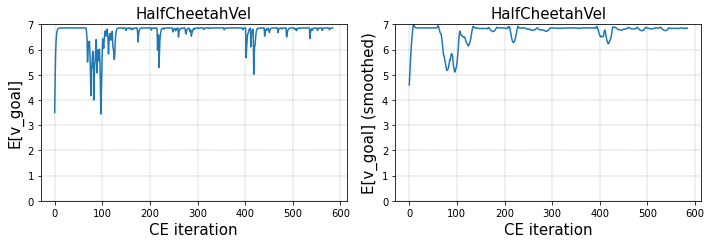

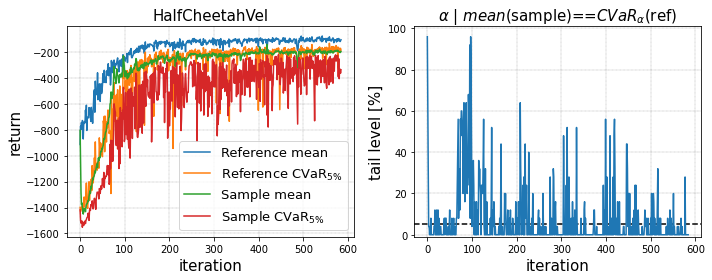

In [4]:
ce, c1, c2, axs1, axs2 = analysis.cem_analysis(
    ENV_NAME, TASK_DIM, TRANSFORMATION, YLIM, SMOOTH, title=TITLE, tasks=TASKS, seed=CEM_SEED)
plt.sca(axs1[0])
plt.savefig(f'outputs/{ENV_SHORT}_sample_dist.png', bbox_inches='tight', dpi=300)
plt.sca(axs2[0])
plt.savefig(f'outputs/{ENV_SHORT}_cem.png', bbox_inches='tight', dpi=300)

## Test results

In [3]:
%%time
rr, rra, rrm, rrc, rr0, rra0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, lambda nm: 'best_mean' if nm=='varibad' else 'best_cvar', nm_map=NM_MAP)
rr

Test tasks: 1008
CPU times: total: 1min 29s
Wall time: 1min 36s


,ep,ret,task0,method,seed
0,0,-127.797058,5.707809,VariBAD,0
1,1,-132.149750,5.707809,VariBAD,0
2,0,-203.905289,6.997781,VariBAD,0
3,1,-224.612717,6.997781,VariBAD,0
4,0,-21.998009,1.272675,VariBAD,0
...,...,...,...,...,...
181435,1,-578.143494,4.374347,CVaR-ML,29
181436,0,-382.253906,1.734606,CVaR-ML,29
181437,1,-431.239380,1.734606,CVaR-ML,29
181438,0,-764.942261,5.859348,CVaR-ML,29


Test returns vs. task - over all seeds aggregated:
CPU times: total: 938 ms
Wall time: 1.08 s


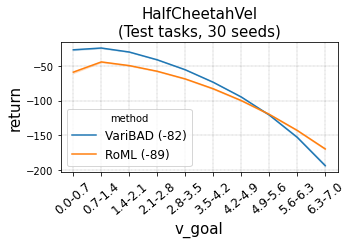

In [18]:
%%time
axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_x_ndigits=1)
plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

In [7]:
# axs = analysis.summarize_test(rra0, rr0, ALPHA)

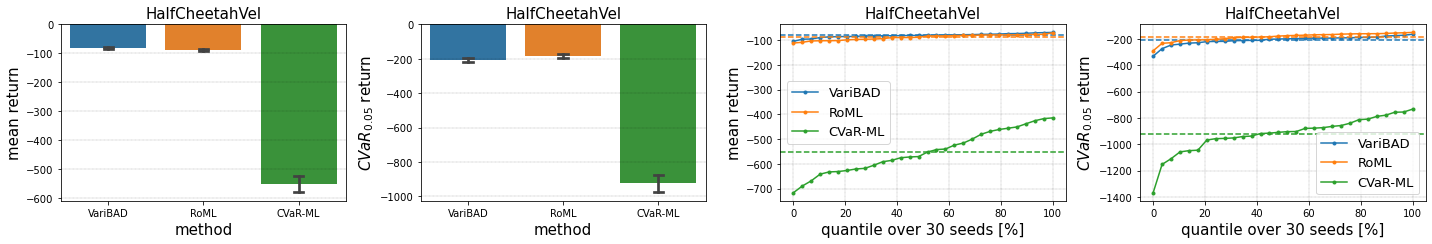

In [8]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE, barplot=True)

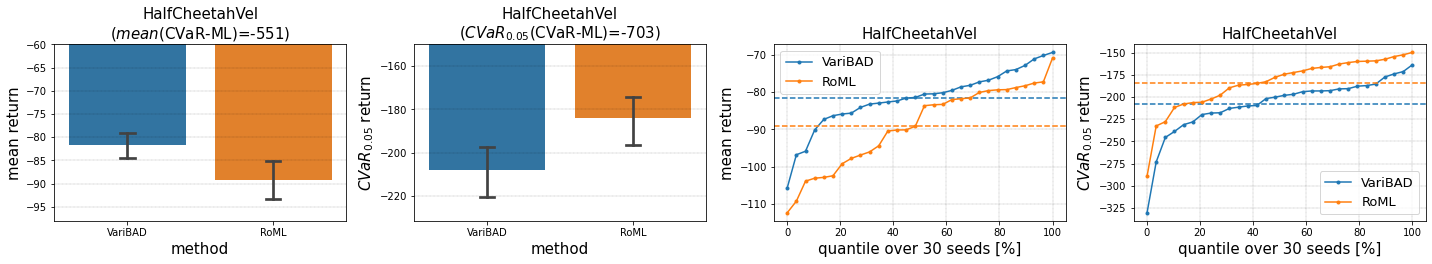

In [9]:
axs = analysis.summarize_test_over_seeds(rrm[rrm.method!='CVaR-ML'], rrc[rrc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_title(f'{TITLE}\n($mean$(CVaR-ML)={rrm.ret[rrm.method=="CVaR-ML"].mean():.0f})', fontsize=15)
axs[0].set_ylim((None, -60))
axs[1].set_title(f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={analysis.get_cvar_fun(ALPHA)(rrm.ret[rrm.method=="CVaR-ML"]):.0f})', fontsize=15)
axs[1].set_ylim((None, -150))
plt.savefig(f'outputs/{ENV_SHORT}_summary.png', bbox_inches='tight', dpi=300)

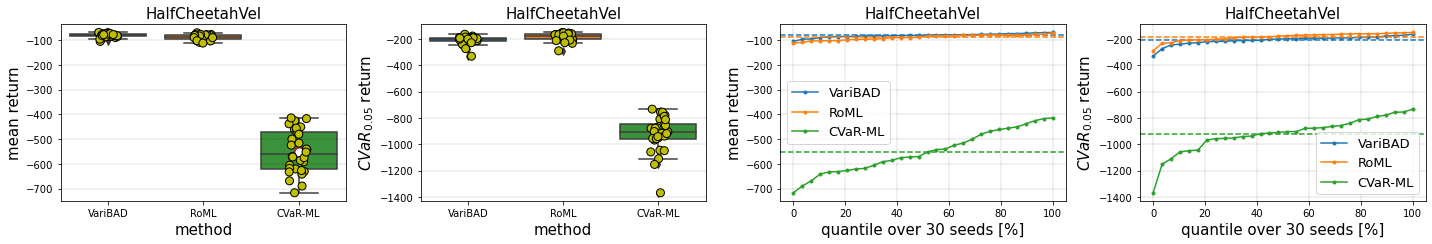

In [10]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE)

### Final models test (not best over validation)

In [3]:
%%time
bb, bba, bbm, bbc, bb0, bba0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'final', nm_map=NM_MAP)

Test tasks: 1008
CPU times: total: 26.5 s
Wall time: 1min 15s


Test tasks: 1008
Test returns vs. task - over all seeds aggregated:
CPU times: total: 1min 40s
Wall time: 1min 49s


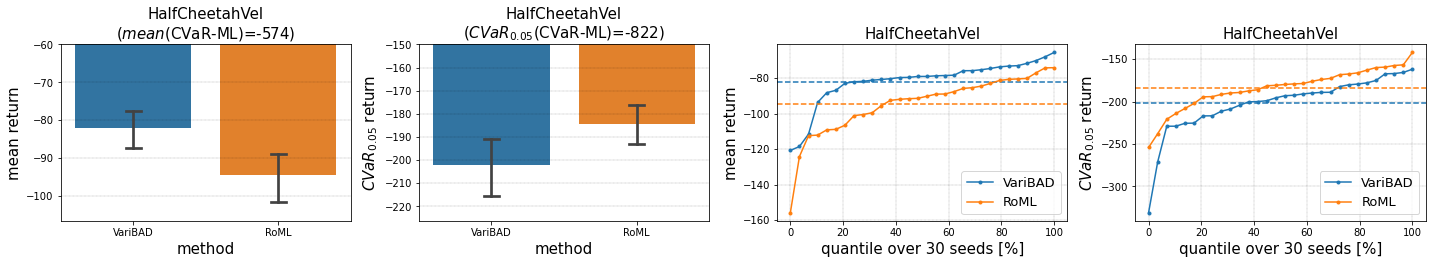

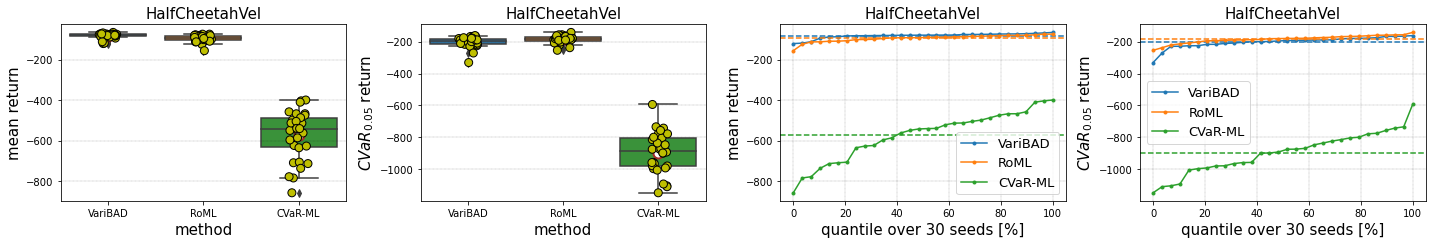

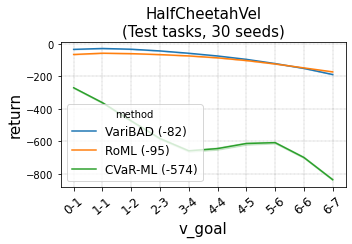

In [4]:
axs = analysis.summarize_test_over_seeds(bbm[bbm.method!='CVaR-ML'], bbc[bbc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_ylim((None, -60))
axs[1].set_ylim((None, -150))

axs = analysis.summarize_test_over_seeds(bbm, bbc, ALPHA, TITLE)
axs2 = analysis.show_test_vs_tasks(bba, bba0, TITLE, TASKS)

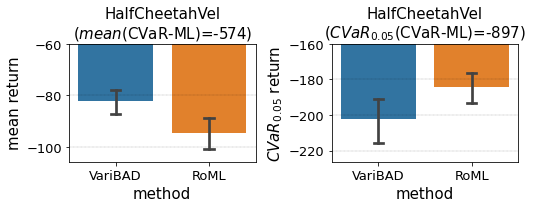

In [26]:
axs = utils.Axes(2, 2, (3.7,3.0), fontsize=15)
a = 0

sns.barplot(data=bbm[bbm.method!='CVaR-ML'], x='method', y='ret', ci=95, capsize=0.1, ax=axs[a])
axs[a].set_ylim((None, -60))
axs[a].tick_params(axis='both', which='major', labelsize=13)
axs.labs(a, 'method', f'mean return', f'{TITLE}\n($mean$(CVaR-ML)={bbm.ret[bbm.method=="CVaR-ML"].mean():.0f})')
a += 1

sns.barplot(data=bbc[bbc.method!='CVaR-ML'], x='method', y='ret', ci=95, capsize=0.1, ax=axs[a])
axs[a].set_ylim((None, -160))
axs[a].tick_params(axis='both', which='major', labelsize=13)
axs.labs(a, 'method', f'$CVaR_{{{ALPHA}}}$ return', f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={bbc.ret[bbc.method=="CVaR-ML"].mean():.0f})')
a += 1

plt.tight_layout()
plt.savefig(f'outputs/{ENV_SHORT}_f_summary.png', bbox_inches='tight', dpi=300)

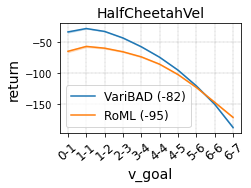

In [27]:
# axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_x_ndigits=1)

task_dim = analysis.get_task_dim(bba)
axs = utils.Axes(task_dim, task_dim, (3.6,2.5), fontsize=14)
a = 0
for i in range(task_dim):
    utils.compare_quantiles(bba[bba.method!='CVaR-ML'], f'task{i:d}', 'ret', 'method',
                            xbins=11, lab_rotation=40, axs=axs, a0=a, ci=95)
    axs.labs(a, TASKS[i], 'return', TITLE)
    axs[a].legend(fontsize=12)
    a += 1

plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

## Validation results

In [3]:
%%time
dd, dda, ddm, ddc, dd0, dda0, task_dim = analysis.load_train_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, nm_map=NM_MAP)
dd

hcv_varibad_0__27_10_20_14_58
hcv_varibad_1__28_10_05_07_33
hcv_varibad_2__28_10_14_12_39
hcv_varibad_3__28_10_23_17_28
hcv_varibad_4__29_10_08_24_24
hcv_varibad_5__29_10_17_29_49
hcv_varibad_6__30_10_01_34_48
hcv_varibad_7__30_10_10_40_32
hcv_varibad_8__30_10_19_32_42
hcv_varibad_9__31_10_03_21_28
hcv_varibad_10__19_11_15_14_48
hcv_varibad_11__20_11_00_13_28
hcv_varibad_12__20_11_09_11_26
hcv_varibad_13__20_11_18_10_06
hcv_varibad_14__21_11_03_07_52
hcv_varibad_15__21_11_12_06_24
hcv_varibad_16__21_11_20_46_30
hcv_varibad_17__22_11_05_08_04
hcv_varibad_18__22_11_13_30_00
hcv_varibad_19__22_11_21_52_17
hcv_varibad_20__23_11_06_13_58
hcv_varibad_21__23_11_14_22_12
hcv_varibad_22__23_11_22_44_49
hcv_varibad_23__24_11_07_07_13
hcv_varibad_24__24_11_15_30_04
hcv_varibad_25__24_11_23_52_36
hcv_varibad_26__25_11_08_14_45
hcv_varibad_27__25_11_16_37_37
hcv_varibad_28__26_11_01_00_34
hcv_varibad_29__26_11_09_24_11
hcv_cembad_0__27_10_20_15_00
hcv_cembad_1__28_10_05_12_08
hcv_cembad_2__28_10_14

,iter,task_id,ep,ret,task0,method,seed
0,-1,0,0,-106.341248,0.360242,VariBAD,0
1,-1,0,1,-136.573456,0.360242,VariBAD,0
2,-1,1,0,-193.122650,0.846701,VariBAD,0
3,-1,1,1,-185.777267,0.846701,VariBAD,0
4,-1,2,0,-538.239807,2.438226,VariBAD,0
...,...,...,...,...,...,...,...
631675,4674,29,1,-823.239685,4.721975,CVaR-ML,29
631676,4674,30,0,-781.750610,4.960962,CVaR-ML,29
631677,4674,30,1,-816.409546,4.960962,CVaR-ML,29
631678,4674,31,0,-759.214417,4.476079,CVaR-ML,29


In [13]:
# axs = analysis.show_task_distribution(dda0, rra0, TASKS)

In [14]:
# %%time
# axs = analysis.show_validation_vs_tasks(dda, TASKS)

In [15]:
# %%time
# axs = analysis.show_validation_results(dda0, ALPHA)

CPU times: total: 24.9 s
Wall time: 26.8 s


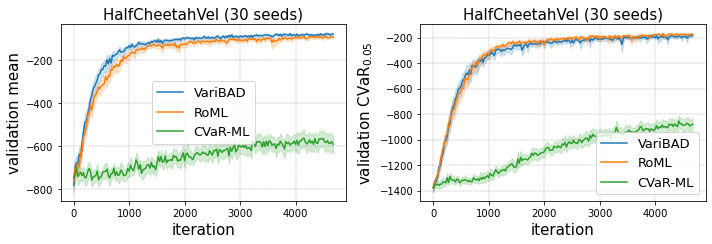

In [4]:
%%time
axs = analysis.show_validation_results_over_seeds(ddm, ddc, ALPHA, TITLE, ci=95, axsize=(5,3.5))
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
# axs[1].set_ylim((-600,-100))
plt.savefig(f'outputs/{ENV_SHORT}_valid.png', bbox_inches='tight', dpi=300)